In [1]:
import warnings
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

import optuna
from catboost import CatBoostClassifier
warnings.simplefilter('ignore', FutureWarning)

!pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0


In [2]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE

In [3]:
train_df = pd.read_csv('/kaggle/input/data-split/train_split/10/train_october.csv')
test_df = pd.read_csv('/kaggle/input/data-split/train_split/10/test_october.csv')

In [4]:
X_train = train_df.drop(columns=['AWS', 'datetime', 'row','col'])
y_train = train_df['AWS']

X_test = test_df.drop(columns=['AWS', 'datetime', 'row','col'])
y_test = test_df['AWS']

## Chuẩn hóa

In [5]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## Chọn feature

In [6]:
top_features =  ['EWSS', 'KX', 'PEV', 'R250', 'R500', 'R850', 'SSHF', 'TCLW', 'TCW', 'U250', 'U850', 'V250', 'V850', 'B11B', 'B14B', 'I4B', 'IRB']

## Hàm bổ trợ

In [7]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()

total = neg + pos

# Tính trọng số tỉ lệ nghịch với tần suất
w0 = total / (2 * neg) 
w1 = total / (2 * pos) 

class_weights = [w0, w1]
print(f"class_weights = {class_weights}")

class_weights = [0.5943266361466951, 3.1503648408621765]


In [8]:
def print_scores(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    print(classification_report(y_true, y_pred))

In [9]:
def train_and_evaluate_cat(X_train, y_train, X_test, y_test, class_weights=None,  top_features=None):
    model_catboost = CatBoostClassifier(
        random_state=42,
        verbose=0,  
        class_weights=class_weights
    )

    if top_features is not None:
        X_train = X_train[top_features]
        X_test = X_test[top_features]

    model_catboost.fit(X_train, y_train)
    y_pred = model_catboost.predict(X_test)
    print_scores(y_test, y_pred)

In [10]:
def objective(trial, X_train_scaled, y_train, X_test_scaled, y_test, 
              use_smote=False, use_smoteenn=False, 
              class_weights=None, top_features=None):
    # Tối ưu các tham số cho CatBoost
    param = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_strength': trial.suggest_float('random_strength', 0.1, 1.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_seed': 42,
        'verbose': 0,
        'allow_writing_files': False,
        'class_weights': class_weights if not (use_smote or use_smoteenn) else None
    }

    # Sử dụng top_features nếu được cung cấp
    if top_features is not None:
        X_train_scaled = X_train_scaled[top_features]
        X_test_scaled = X_test_scaled[top_features]

    model = CatBoostClassifier(**param)
    model.fit(X_train_scaled, y_train)

    # Dự đoán và tối ưu threshold
    y_probs = model.predict_proba(X_test_scaled)[:, 1]
    best_thresh = trial.suggest_float('threshold', 0.1, 0.9, step=0.05)
    y_pred = (y_probs >= best_thresh).astype(int)

    return f1_score(y_test, y_pred, pos_label=1)


In [11]:
def optimize_and_train_catboost(X_train, y_train, X_test, y_test,
                                use_smote=False, use_smoteenn=False,
                                class_weights=None, top_features=None,
                                n_trials=50):
    study = optuna.create_study(direction='maximize')

    # Tối ưu hóa tham số
    study.optimize(lambda trial: objective(
                        trial, X_train, y_train, X_test, y_test,
                        use_smote, use_smoteenn, class_weights, top_features),
                   n_trials=n_trials)

    # In kết quả tốt nhất
    print("Best trial:")
    print(study.best_trial)
    print("Best hyperparameters:")
    for key, value in study.best_trial.params.items():
        print(f"{key}: {value}")

    # Huấn luyện lại với tham số tốt nhất
    best_params = study.best_trial.params
    best_thresh = best_params.pop('threshold')

    best_params.update({
        'random_seed': 42,
        'verbose': 0,
        'loss_function': 'Logloss',
        'eval_metric': 'F1'
    })

    if class_weights:
        best_params['class_weights'] = class_weights

    best_model = CatBoostClassifier(**best_params)

    # Chọn đặc trưng nếu có
    if top_features is not None:
        X_train_use = X_train[top_features]
        X_test_use = X_test[top_features]
    else:
        X_train_use = X_train
        X_test_use = X_test

    best_model.fit(X_train_use, y_train)
    y_probs = best_model.predict_proba(X_test_use)[:, 1]
    y_pred_thresh = (y_probs >= best_thresh).astype(int)

    print(f"Best threshold: {best_thresh}")
    print_scores(y_test, y_pred_thresh)


# Không SMOTE

## Data

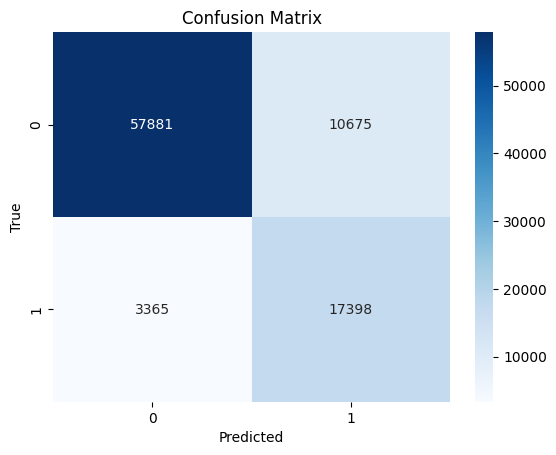

              precision    recall  f1-score   support

           0       0.95      0.84      0.89     68556
           1       0.62      0.84      0.71     20763

    accuracy                           0.84     89319
   macro avg       0.78      0.84      0.80     89319
weighted avg       0.87      0.84      0.85     89319



In [12]:
train_and_evaluate_cat(X_train_scaled, y_train, X_test_scaled, y_test,  class_weights=class_weights)

## Data tune

[I 2025-05-05 19:27:49,655] A new study created in memory with name: no-name-9bb8dee4-db41-4933-9b41-dd9acc7a1579
[I 2025-05-05 19:27:53,102] Trial 0 finished with value: 0.6716265360937462 and parameters: {'iterations': 110, 'learning_rate': 0.026076592607354926, 'depth': 3, 'l2_leaf_reg': 6.742676617953314, 'random_strength': 0.2407647002713846, 'bagging_temperature': 0.1902923368495174, 'threshold': 0.35}. Best is trial 0 with value: 0.6716265360937462.
[I 2025-05-05 19:28:14,871] Trial 1 finished with value: 0.7032703518418987 and parameters: {'iterations': 267, 'learning_rate': 0.1180813421518228, 'depth': 9, 'l2_leaf_reg': 7.161694496735272, 'random_strength': 0.42040423197771737, 'bagging_temperature': 0.4115082533407961, 'threshold': 0.2}. Best is trial 1 with value: 0.7032703518418987.
[I 2025-05-05 19:28:32,643] Trial 2 finished with value: 0.6043362912816759 and parameters: {'iterations': 425, 'learning_rate': 0.18935728034150745, 'depth': 6, 'l2_leaf_reg': 7.826997125093512

Best trial:
FrozenTrial(number=38, state=1, values=[0.7185642125966655], datetime_start=datetime.datetime(2025, 5, 5, 19, 41, 51, 899710), datetime_complete=datetime.datetime(2025, 5, 5, 19, 42, 0, 481924), params={'iterations': 226, 'learning_rate': 0.18261220272315165, 'depth': 5, 'l2_leaf_reg': 5.936446559915526, 'random_strength': 0.8681245309159612, 'bagging_temperature': 0.44739168009193997, 'threshold': 0.30000000000000004}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=500, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'depth': IntDistribution(high=10, log=False, low=3, step=1), 'l2_leaf_reg': FloatDistribution(high=10.0, log=False, low=1.0, step=None), 'random_strength': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'bagging_temperature': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'threshold': FloatDistribution(high=0.9, log=Fa

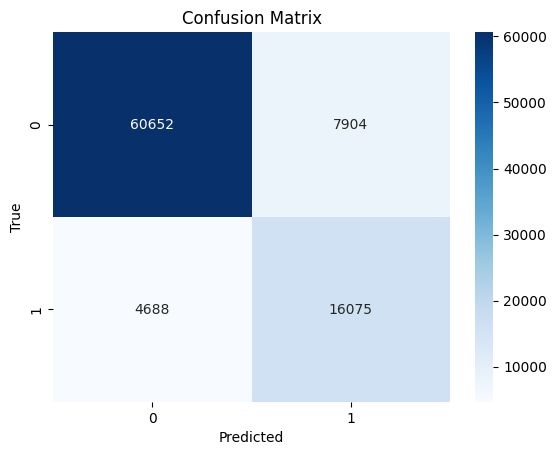

              precision    recall  f1-score   support

           0       0.93      0.88      0.91     68556
           1       0.67      0.77      0.72     20763

    accuracy                           0.86     89319
   macro avg       0.80      0.83      0.81     89319
weighted avg       0.87      0.86      0.86     89319



In [13]:
optimize_and_train_catboost(X_train_scaled, y_train, X_test_scaled, y_test)

## Data + feature

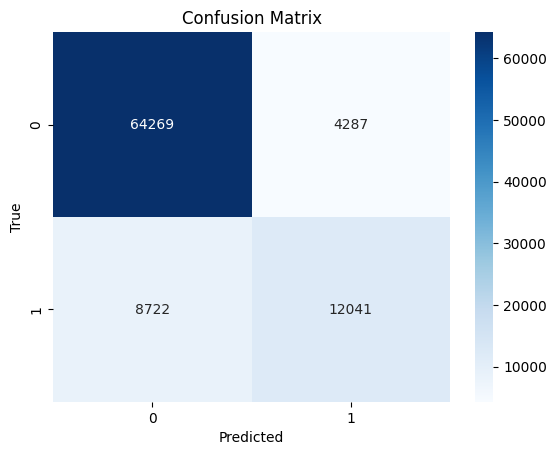

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     68556
           1       0.74      0.58      0.65     20763

    accuracy                           0.85     89319
   macro avg       0.81      0.76      0.78     89319
weighted avg       0.85      0.85      0.85     89319



In [14]:
train_and_evaluate_cat(X_train_scaled, y_train, X_test_scaled, y_test, top_features=top_features)

## Data + Feature + Tune

[I 2025-05-05 19:44:05,668] A new study created in memory with name: no-name-9c6bad54-0178-4b39-b66b-010761b4c9bd
[I 2025-05-05 19:44:20,915] Trial 0 finished with value: 0.1516086381665932 and parameters: {'iterations': 476, 'learning_rate': 0.01160450626243488, 'depth': 5, 'l2_leaf_reg': 7.0280086889202815, 'random_strength': 0.47905949055734476, 'bagging_temperature': 0.5898251103763873, 'threshold': 0.9}. Best is trial 0 with value: 0.1516086381665932.
[I 2025-05-05 19:44:36,920] Trial 1 finished with value: 0.6908314606741573 and parameters: {'iterations': 314, 'learning_rate': 0.06786105266694924, 'depth': 8, 'l2_leaf_reg': 7.718083949810071, 'random_strength': 0.20249410906385365, 'bagging_temperature': 0.3497737191842034, 'threshold': 0.35}. Best is trial 1 with value: 0.6908314606741573.
[I 2025-05-05 19:44:39,733] Trial 2 finished with value: 0.6512634634875372 and parameters: {'iterations': 123, 'learning_rate': 0.28697011656426574, 'depth': 5, 'l2_leaf_reg': 9.4917013167492

Best trial:
FrozenTrial(number=4, state=1, values=[0.6993987975951903], datetime_start=datetime.datetime(2025, 5, 5, 19, 44, 52, 828322), datetime_complete=datetime.datetime(2025, 5, 5, 19, 45, 1, 759601), params={'iterations': 298, 'learning_rate': 0.13614980875011756, 'depth': 4, 'l2_leaf_reg': 1.5130068058564978, 'random_strength': 0.8369407677413807, 'bagging_temperature': 0.5230527184321483, 'threshold': 0.35}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=500, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'depth': IntDistribution(high=10, log=False, low=3, step=1), 'l2_leaf_reg': FloatDistribution(high=10.0, log=False, low=1.0, step=None), 'random_strength': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'bagging_temperature': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'threshold': FloatDistribution(high=0.9, log=False, low=0.1, st

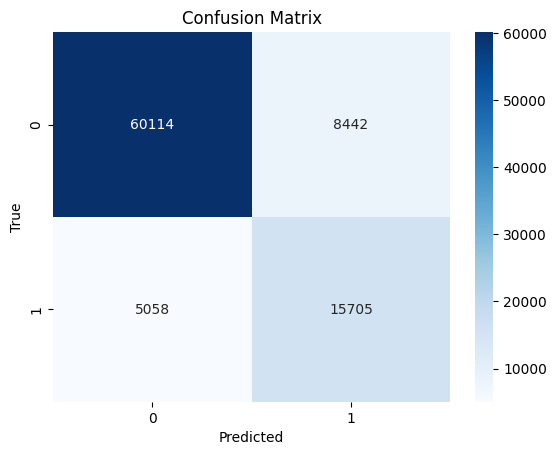

              precision    recall  f1-score   support

           0       0.92      0.88      0.90     68556
           1       0.65      0.76      0.70     20763

    accuracy                           0.85     89319
   macro avg       0.79      0.82      0.80     89319
weighted avg       0.86      0.85      0.85     89319



In [15]:
optimize_and_train_catboost(X_train_scaled, y_train, X_test_scaled, y_test, top_features=top_features)

## Data + class_weights

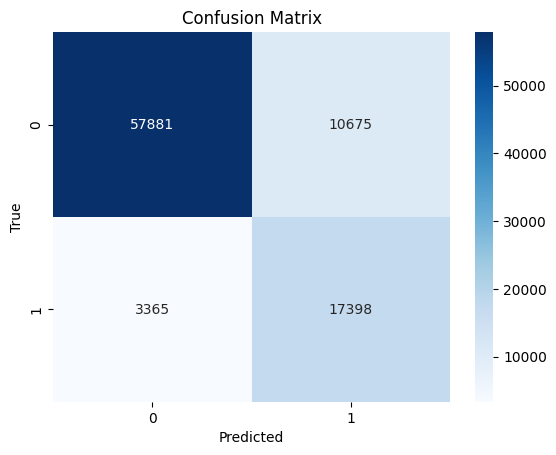

              precision    recall  f1-score   support

           0       0.95      0.84      0.89     68556
           1       0.62      0.84      0.71     20763

    accuracy                           0.84     89319
   macro avg       0.78      0.84      0.80     89319
weighted avg       0.87      0.84      0.85     89319



In [16]:
train_and_evaluate_cat(X_train_scaled, y_train, X_test_scaled, y_test, class_weights=class_weights)

## Data + class_weights + Tune

[I 2025-05-05 19:55:45,811] A new study created in memory with name: no-name-8779dc25-e4d6-420e-9cd6-561e366b4b9e
[I 2025-05-05 19:56:10,562] Trial 0 finished with value: 0.5521990515169233 and parameters: {'iterations': 394, 'learning_rate': 0.22958270780124132, 'depth': 8, 'l2_leaf_reg': 6.3661970223734325, 'random_strength': 0.329427002061023, 'bagging_temperature': 0.6367892216198171, 'threshold': 0.9}. Best is trial 0 with value: 0.5521990515169233.
[I 2025-05-05 19:56:34,281] Trial 1 finished with value: 0.6819325147658886 and parameters: {'iterations': 158, 'learning_rate': 0.24144557596854907, 'depth': 10, 'l2_leaf_reg': 3.5099999233560712, 'random_strength': 0.33753262017899394, 'bagging_temperature': 0.6706751917273805, 'threshold': 0.30000000000000004}. Best is trial 1 with value: 0.6819325147658886.
[I 2025-05-05 19:57:11,875] Trial 2 finished with value: 0.6991246148509397 and parameters: {'iterations': 250, 'learning_rate': 0.1832620172129356, 'depth': 10, 'l2_leaf_reg': 

Best trial:
FrozenTrial(number=23, state=1, values=[0.7168963247145355], datetime_start=datetime.datetime(2025, 5, 5, 20, 3, 13, 540973), datetime_complete=datetime.datetime(2025, 5, 5, 20, 3, 34, 437021), params={'iterations': 411, 'learning_rate': 0.09592542732418835, 'depth': 7, 'l2_leaf_reg': 9.093058045033745, 'random_strength': 0.6065040769113619, 'bagging_temperature': 0.40901496388876774, 'threshold': 0.65}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=500, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'depth': IntDistribution(high=10, log=False, low=3, step=1), 'l2_leaf_reg': FloatDistribution(high=10.0, log=False, low=1.0, step=None), 'random_strength': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'bagging_temperature': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'threshold': FloatDistribution(high=0.9, log=False, low=0.1, st

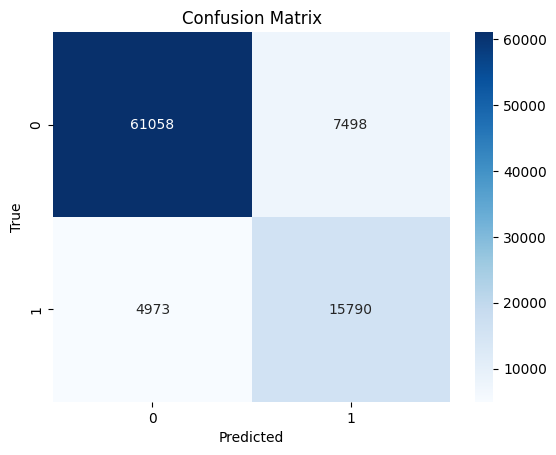

              precision    recall  f1-score   support

           0       0.92      0.89      0.91     68556
           1       0.68      0.76      0.72     20763

    accuracy                           0.86     89319
   macro avg       0.80      0.83      0.81     89319
weighted avg       0.87      0.86      0.86     89319



In [17]:
optimize_and_train_catboost(X_train_scaled, y_train, X_test_scaled, y_test,class_weights=class_weights)

## Data + class_weights + feature 

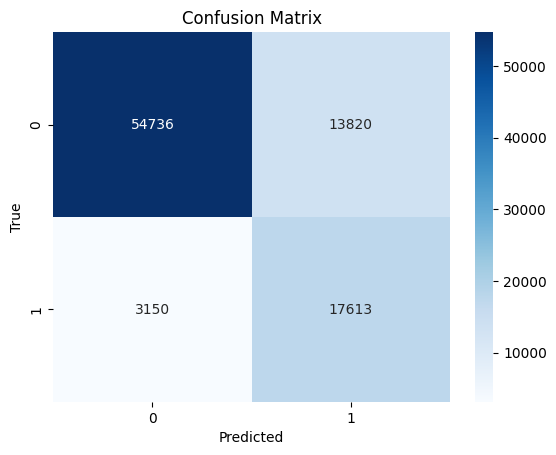

              precision    recall  f1-score   support

           0       0.95      0.80      0.87     68556
           1       0.56      0.85      0.67     20763

    accuracy                           0.81     89319
   macro avg       0.75      0.82      0.77     89319
weighted avg       0.86      0.81      0.82     89319



In [18]:
train_and_evaluate_cat(X_train_scaled, y_train, X_test_scaled, y_test, class_weights=class_weights, top_features=top_features)

## Data + class_weights + feature + tune

[I 2025-05-05 20:11:49,486] A new study created in memory with name: no-name-a89e6563-323f-4fc4-979a-f0e1cd53879f
[I 2025-05-05 20:12:06,748] Trial 0 finished with value: 0.5500226408880717 and parameters: {'iterations': 334, 'learning_rate': 0.219366320805776, 'depth': 8, 'l2_leaf_reg': 2.727372735988867, 'random_strength': 0.8747439551464239, 'bagging_temperature': 0.9691745476036758, 'threshold': 0.1}. Best is trial 0 with value: 0.5500226408880717.
[I 2025-05-05 20:12:17,202] Trial 1 finished with value: 0.5180656639171923 and parameters: {'iterations': 239, 'learning_rate': 0.2981715929052344, 'depth': 7, 'l2_leaf_reg': 7.417394807265754, 'random_strength': 0.9190255831769153, 'bagging_temperature': 0.6642574613021254, 'threshold': 0.9}. Best is trial 0 with value: 0.5500226408880717.
[I 2025-05-05 20:12:28,073] Trial 2 finished with value: 0.6890132722723995 and parameters: {'iterations': 265, 'learning_rate': 0.22425773317678052, 'depth': 6, 'l2_leaf_reg': 6.854570326635939, 'ra

Best trial:
FrozenTrial(number=43, state=1, values=[0.6937459703417149], datetime_start=datetime.datetime(2025, 5, 5, 20, 20, 30, 318299), datetime_complete=datetime.datetime(2025, 5, 5, 20, 20, 41, 606976), params={'iterations': 286, 'learning_rate': 0.027073754589610366, 'depth': 6, 'l2_leaf_reg': 4.299870504792812, 'random_strength': 0.30470366944036215, 'bagging_temperature': 0.33161557992038765, 'threshold': 0.75}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=500, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'depth': IntDistribution(high=10, log=False, low=3, step=1), 'l2_leaf_reg': FloatDistribution(high=10.0, log=False, low=1.0, step=None), 'random_strength': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'bagging_temperature': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'threshold': FloatDistribution(high=0.9, log=False, low=0.1

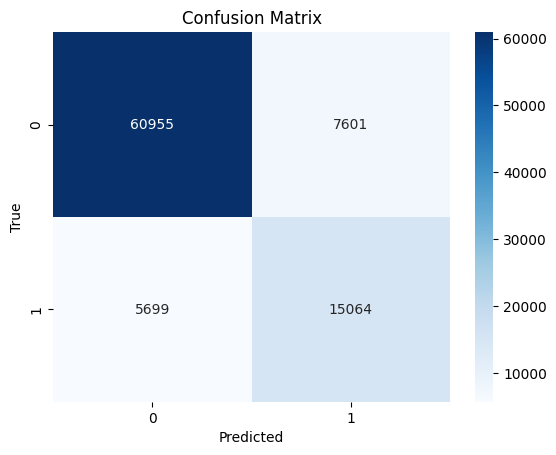

              precision    recall  f1-score   support

           0       0.91      0.89      0.90     68556
           1       0.66      0.73      0.69     20763

    accuracy                           0.85     89319
   macro avg       0.79      0.81      0.80     89319
weighted avg       0.86      0.85      0.85     89319



In [19]:
optimize_and_train_catboost(X_train_scaled, y_train, X_test_scaled, y_test,class_weights=class_weights, top_features = top_features)

# SMOTE

In [20]:
sm = SMOTE()

X_sm, y_sm = sm.fit_resample(X_train, y_train)
X_sm.shape, y_sm.shape

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_sm)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## Data SMOTE 

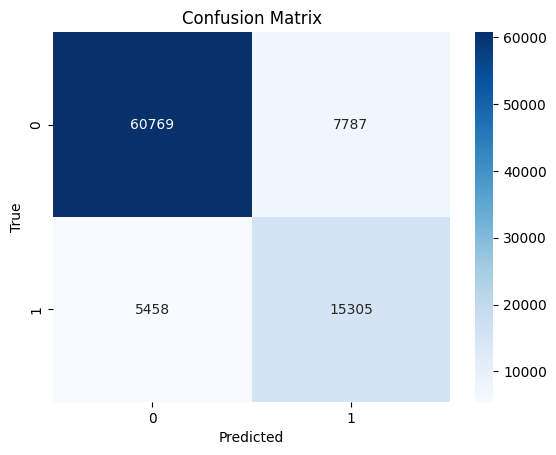

              precision    recall  f1-score   support

           0       0.92      0.89      0.90     68556
           1       0.66      0.74      0.70     20763

    accuracy                           0.85     89319
   macro avg       0.79      0.81      0.80     89319
weighted avg       0.86      0.85      0.85     89319



In [21]:
train_and_evaluate_cat(X_train_scaled, y_sm, X_test_scaled, y_test)

## Data SMOTE + Tune

[I 2025-05-05 20:22:45,988] A new study created in memory with name: no-name-1f92e636-61a2-4d49-94f4-bf5edd78b812
[I 2025-05-05 20:23:05,812] Trial 0 finished with value: 0.6742418625342923 and parameters: {'iterations': 292, 'learning_rate': 0.1863173131149263, 'depth': 6, 'l2_leaf_reg': 2.6262663126485584, 'random_strength': 0.8061101810125643, 'bagging_temperature': 0.4666733505057852, 'threshold': 0.30000000000000004}. Best is trial 0 with value: 0.6742418625342923.
[I 2025-05-05 20:23:19,325] Trial 1 finished with value: 0.6058739083622443 and parameters: {'iterations': 268, 'learning_rate': 0.22798843358217696, 'depth': 3, 'l2_leaf_reg': 4.132111414267664, 'random_strength': 0.2756016366218253, 'bagging_temperature': 0.1921139818886336, 'threshold': 0.85}. Best is trial 0 with value: 0.6742418625342923.
[I 2025-05-05 20:23:34,941] Trial 2 finished with value: 0.6277393218284475 and parameters: {'iterations': 334, 'learning_rate': 0.14179295932491884, 'depth': 3, 'l2_leaf_reg': 2.

Best trial:
FrozenTrial(number=27, state=1, values=[0.7033700077969331], datetime_start=datetime.datetime(2025, 5, 5, 20, 40, 55, 929151), datetime_complete=datetime.datetime(2025, 5, 5, 20, 41, 24, 837527), params={'iterations': 460, 'learning_rate': 0.12516477124673375, 'depth': 5, 'l2_leaf_reg': 9.066316523730357, 'random_strength': 0.20188357415544295, 'bagging_temperature': 0.16795244874205684, 'threshold': 0.55}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=500, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'depth': IntDistribution(high=10, log=False, low=3, step=1), 'l2_leaf_reg': FloatDistribution(high=10.0, log=False, low=1.0, step=None), 'random_strength': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'bagging_temperature': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'threshold': FloatDistribution(high=0.9, log=False, low=0.1,

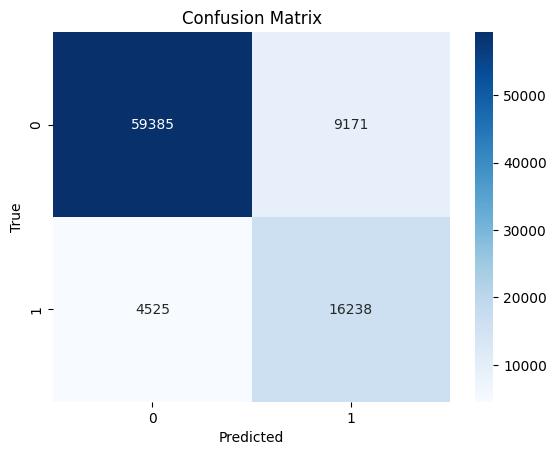

              precision    recall  f1-score   support

           0       0.93      0.87      0.90     68556
           1       0.64      0.78      0.70     20763

    accuracy                           0.85     89319
   macro avg       0.78      0.82      0.80     89319
weighted avg       0.86      0.85      0.85     89319



In [22]:
optimize_and_train_catboost(X_train_scaled, y_sm, X_test_scaled, y_test, use_smote=True)

## Data SMOTE + Feature

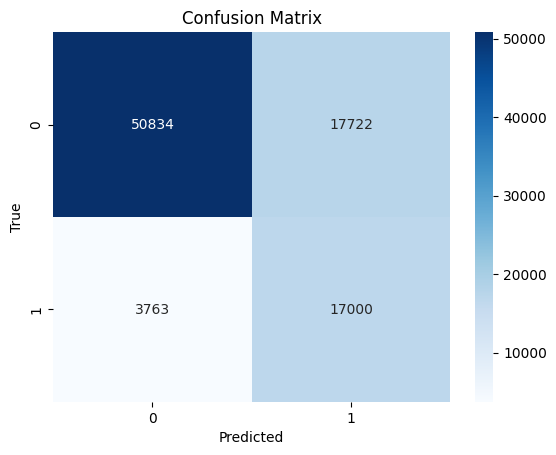

              precision    recall  f1-score   support

           0       0.93      0.74      0.83     68556
           1       0.49      0.82      0.61     20763

    accuracy                           0.76     89319
   macro avg       0.71      0.78      0.72     89319
weighted avg       0.83      0.76      0.78     89319



In [23]:
train_and_evaluate_cat(X_train_scaled, y_sm, X_test_scaled, y_test, top_features = top_features)

## Data SMOTE + Feature + Tune

[I 2025-05-05 20:56:58,457] A new study created in memory with name: no-name-e7435c8b-f3ae-40c4-9386-a52031704121
[I 2025-05-05 20:57:09,487] Trial 0 finished with value: 0.5534176387223374 and parameters: {'iterations': 204, 'learning_rate': 0.02676278902790826, 'depth': 5, 'l2_leaf_reg': 8.830612800902397, 'random_strength': 0.9058905445855969, 'bagging_temperature': 0.7347153043261322, 'threshold': 0.2}. Best is trial 0 with value: 0.5534176387223374.
[I 2025-05-05 20:57:16,166] Trial 1 finished with value: 0.570244402666211 and parameters: {'iterations': 141, 'learning_rate': 0.17301855515560563, 'depth': 7, 'l2_leaf_reg': 5.273822389535535, 'random_strength': 0.8887815907296985, 'bagging_temperature': 0.9079418173801279, 'threshold': 0.2}. Best is trial 1 with value: 0.570244402666211.
[I 2025-05-05 20:57:23,482] Trial 2 finished with value: 0.6619341563786008 and parameters: {'iterations': 189, 'learning_rate': 0.08311651896319452, 'depth': 5, 'l2_leaf_reg': 5.363338886671987, 'r

Best trial:
FrozenTrial(number=49, state=1, values=[0.6728273452891119], datetime_start=datetime.datetime(2025, 5, 5, 21, 7, 57, 156929), datetime_complete=datetime.datetime(2025, 5, 5, 21, 8, 1, 537850), params={'iterations': 117, 'learning_rate': 0.05742039082256285, 'depth': 5, 'l2_leaf_reg': 4.2068314989653075, 'random_strength': 0.8973927150125967, 'bagging_temperature': 0.45612647065858297, 'threshold': 0.7000000000000001}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=500, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'depth': IntDistribution(high=10, log=False, low=3, step=1), 'l2_leaf_reg': FloatDistribution(high=10.0, log=False, low=1.0, step=None), 'random_strength': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'bagging_temperature': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'threshold': FloatDistribution(high=0.9, log=Fals

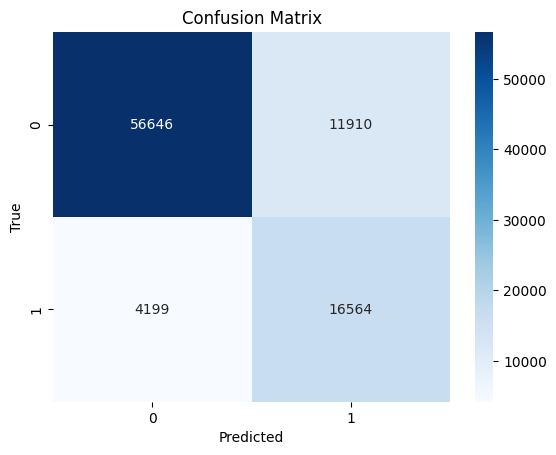

              precision    recall  f1-score   support

           0       0.93      0.83      0.88     68556
           1       0.58      0.80      0.67     20763

    accuracy                           0.82     89319
   macro avg       0.76      0.81      0.77     89319
weighted avg       0.85      0.82      0.83     89319



In [24]:
optimize_and_train_catboost(X_train_scaled, y_sm, X_test_scaled, y_test, top_features=top_features, use_smote = True)

# SMOTE ENN

In [25]:
smenn = SMOTEENN()

X_smenn, y_smenn = smenn.fit_resample(X_train, y_train)
X_smenn.shape, y_sm.shape

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_smenn)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## Data SMOTE ENN 

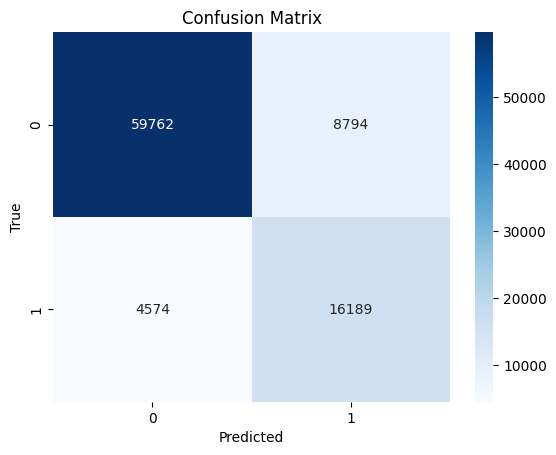

              precision    recall  f1-score   support

           0       0.93      0.87      0.90     68556
           1       0.65      0.78      0.71     20763

    accuracy                           0.85     89319
   macro avg       0.79      0.83      0.80     89319
weighted avg       0.86      0.85      0.85     89319



In [26]:
train_and_evaluate_cat(X_train_scaled, y_smenn, X_test_scaled, y_test)

## Data SMOTE ENN + Tune

[I 2025-05-05 21:17:57,292] A new study created in memory with name: no-name-a290157e-74cc-4427-bd4e-6b85ae0b386d
[I 2025-05-05 21:18:13,496] Trial 0 finished with value: 0.6754681195262091 and parameters: {'iterations': 304, 'learning_rate': 0.05200533078401654, 'depth': 5, 'l2_leaf_reg': 6.594038293973635, 'random_strength': 0.8285528011830019, 'bagging_temperature': 0.4795943350620119, 'threshold': 0.45000000000000007}. Best is trial 0 with value: 0.6754681195262091.
[I 2025-05-05 21:18:45,292] Trial 1 finished with value: 0.6846410934304384 and parameters: {'iterations': 321, 'learning_rate': 0.051141824627917935, 'depth': 9, 'l2_leaf_reg': 9.504526108740443, 'random_strength': 0.8784342306694114, 'bagging_temperature': 0.9931501446628082, 'threshold': 0.8}. Best is trial 1 with value: 0.6846410934304384.
[I 2025-05-05 21:18:52,033] Trial 2 finished with value: 0.6095600928626704 and parameters: {'iterations': 163, 'learning_rate': 0.033408017223404494, 'depth': 3, 'l2_leaf_reg': 5

Best trial:
FrozenTrial(number=25, state=1, values=[0.7122984439766488], datetime_start=datetime.datetime(2025, 5, 5, 21, 27, 51, 775095), datetime_complete=datetime.datetime(2025, 5, 5, 21, 28, 13, 448138), params={'iterations': 478, 'learning_rate': 0.26921517231219805, 'depth': 4, 'l2_leaf_reg': 4.634848301570677, 'random_strength': 0.38845406895762846, 'bagging_temperature': 0.8768198543022415, 'threshold': 0.6}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=500, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'depth': IntDistribution(high=10, log=False, low=3, step=1), 'l2_leaf_reg': FloatDistribution(high=10.0, log=False, low=1.0, step=None), 'random_strength': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'bagging_temperature': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'threshold': FloatDistribution(high=0.9, log=False, low=0.1, s

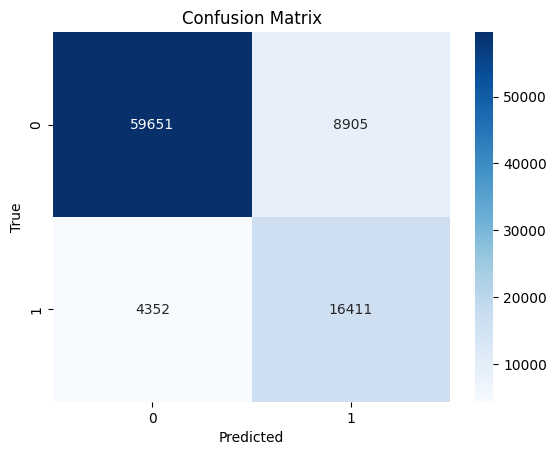

              precision    recall  f1-score   support

           0       0.93      0.87      0.90     68556
           1       0.65      0.79      0.71     20763

    accuracy                           0.85     89319
   macro avg       0.79      0.83      0.81     89319
weighted avg       0.87      0.85      0.86     89319



In [27]:
optimize_and_train_catboost(X_train_scaled, y_smenn, X_test_scaled, y_test, use_smoteenn = True)

## Data SMOTE ENN + Feature

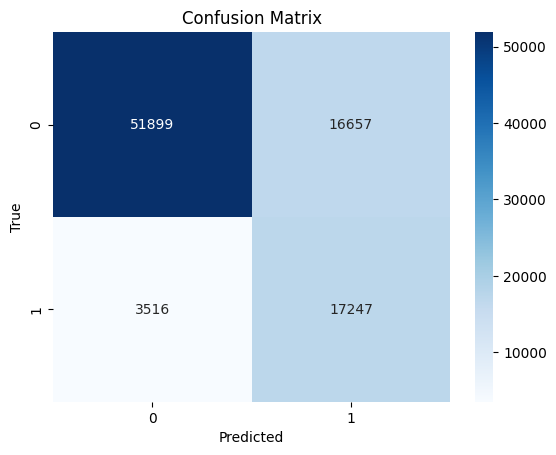

              precision    recall  f1-score   support

           0       0.94      0.76      0.84     68556
           1       0.51      0.83      0.63     20763

    accuracy                           0.77     89319
   macro avg       0.72      0.79      0.73     89319
weighted avg       0.84      0.77      0.79     89319



In [28]:
train_and_evaluate_cat(X_train_scaled, y_smenn, X_test_scaled, y_test, top_features = top_features)

## Data SMOTE ENN + Feature + Tune

[I 2025-05-05 21:37:48,638] A new study created in memory with name: no-name-6a093303-c131-4cb2-8733-f857bc14980d
[I 2025-05-05 21:38:00,468] Trial 0 finished with value: 0.6595840425740056 and parameters: {'iterations': 269, 'learning_rate': 0.2291214871917766, 'depth': 5, 'l2_leaf_reg': 6.185353341960627, 'random_strength': 0.19182306877246724, 'bagging_temperature': 0.869764295334195, 'threshold': 0.65}. Best is trial 0 with value: 0.6595840425740056.
[I 2025-05-05 21:38:18,267] Trial 1 finished with value: 0.6023269976601814 and parameters: {'iterations': 215, 'learning_rate': 0.2043469047191189, 'depth': 9, 'l2_leaf_reg': 6.623079963351316, 'random_strength': 0.7599660675364088, 'bagging_temperature': 0.4102970052243178, 'threshold': 0.30000000000000004}. Best is trial 0 with value: 0.6595840425740056.
[I 2025-05-05 21:38:23,688] Trial 2 finished with value: 0.6656919158569946 and parameters: {'iterations': 139, 'learning_rate': 0.08517153597740891, 'depth': 7, 'l2_leaf_reg': 3.95

Best trial:
FrozenTrial(number=26, state=1, values=[0.6790926674872515], datetime_start=datetime.datetime(2025, 5, 5, 21, 44, 21, 516072), datetime_complete=datetime.datetime(2025, 5, 5, 21, 44, 33, 859302), params={'iterations': 317, 'learning_rate': 0.04386942046659199, 'depth': 4, 'l2_leaf_reg': 3.295962045281927, 'random_strength': 0.243958638307074, 'bagging_temperature': 0.531399581368139, 'threshold': 0.8}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=500, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'depth': IntDistribution(high=10, log=False, low=3, step=1), 'l2_leaf_reg': FloatDistribution(high=10.0, log=False, low=1.0, step=None), 'random_strength': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'bagging_temperature': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'threshold': FloatDistribution(high=0.9, log=False, low=0.1, step

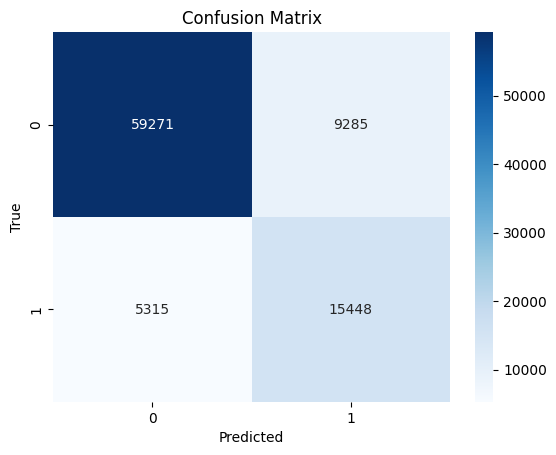

              precision    recall  f1-score   support

           0       0.92      0.86      0.89     68556
           1       0.62      0.74      0.68     20763

    accuracy                           0.84     89319
   macro avg       0.77      0.80      0.78     89319
weighted avg       0.85      0.84      0.84     89319



In [29]:
optimize_and_train_catboost(X_train_scaled, y_smenn, X_test_scaled, y_test, top_features=top_features,  use_smoteenn = True)